1- Importing Libraries.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

2- Load and Preprocess Dataset.

In [10]:
# Load dataset
dataset = pd.read_csv("Housing.csv")

# Separate features and target
features = dataset.drop(columns=['price'])
target = dataset['price']

# Train-test split
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Normalize features (z-score normalization)
numeric_features_train = features_train.select_dtypes(include=[np.number])
numeric_features_test = features_test.select_dtypes(include=[np.number])

features_train_normalized = (numeric_features_train - numeric_features_train.mean()) / numeric_features_train.std()
features_test_normalized = (numeric_features_test - numeric_features_train.mean()) / numeric_features_train.std()

# Store mean and std of the target for scaling predictions back
target_mean = target_train.mean()
target_std = target_train.std()


3- Implement the Absolute Trick.

In [12]:
def absolute_trick(base_price, price_per_room, num_rooms, price, learning_rate):
    predicted_price = base_price + price_per_room * num_rooms
    if price > predicted_price:
        price_per_room += learning_rate * num_rooms
        base_price += learning_rate
    else:
        price_per_room -= learning_rate * num_rooms
        base_price -= learning_rate
    return price_per_room, base_price

In [13]:
class AbsoluteTrickLinearRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.price_per_room = 0
        self.base_price = 0

    def fit(self, X, y):
        num_samples = X.shape[0]
        
        # Training loop
        for _ in range(self.iterations):
            for i in range(num_samples):
                # Assumes the first feature is the number of rooms
                num_rooms = X[i, 0]  # Use the first column as the feature
                price = y[i]

                # Update parameters using the absolute trick
                self.price_per_room, self.base_price = absolute_trick(
                    self.base_price, self.price_per_room, num_rooms, price, self.learning_rate
                )

    def predict(self, X):
        return self.base_price + self.price_per_room * X[:, 0]

4- Train and Evaluate the Absolute Trick Model.

In [15]:
# Convert normalized features and targets to numpy arrays
X_train = features_train_normalized.values  # Explicitly convert to numpy array
X_test = features_test_normalized.values   # Explicitly convert to numpy array
y_train = ((target_train - target_mean) / target_std).values  # Normalize the target and ensure it's numpy

# Initialize and train the model
model = AbsoluteTrickLinearRegression(learning_rate=0.01, iterations=1000)
model.fit(X_train, y_train)

In [16]:
# Make predictions
y_pred_normalized = model.predict(X_test)

# Rescale predictions back to the original target scale
y_pred = y_pred_normalized * target_std + target_mean


In [17]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(target_test, y_pred))
r2 = r2_score(target_test, y_pred)

print("Absolute Trick Linear Regression RMSE:", rmse)
print("Absolute Trick Linear Regression R^2:", r2)


Absolute Trick Linear Regression RMSE: 1918836.5989890299
Absolute Trick Linear Regression R^2: 0.2715634140664104


5- Visualize Results.

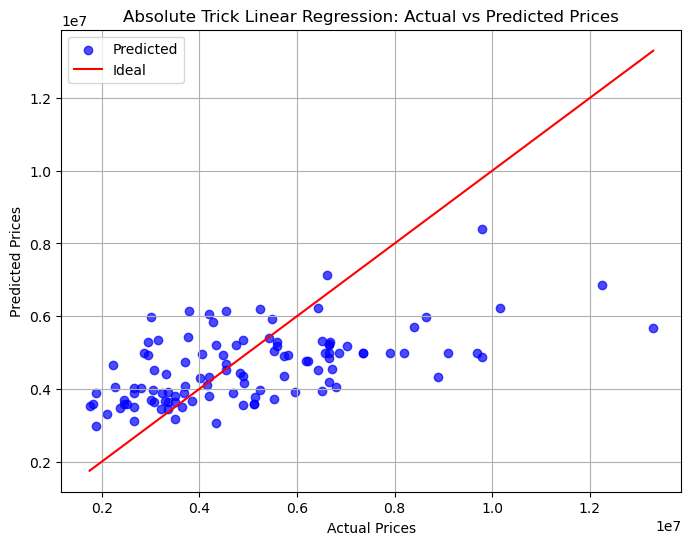

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(target_test, y_pred, color='blue', label='Predicted', alpha=0.7)
plt.plot([min(target_test), max(target_test)], [min(target_test), max(target_test)], color='red', label='Ideal')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Absolute Trick Linear Regression: Actual vs Predicted Prices")
plt.legend()
plt.grid()
plt.show()
